In [1]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch 
from torch.utils.data import DataLoader
import torchvision 
from torchvision import transforms
from torchsummary import summary

root = os.path.abspath(os.path.join(os.path.dirname("."), '..'))
sys.path.insert(0, root)

from src.utils.io import load_dataset
from src.utils.util import *
from src.utils.augment import CustomAugmentation
from src.models.unet import UNet
from src.models.res_unet import ResUNet
from src.models.res_attn_unet import ResAttentionUNet
from src.loader.datasets import ScribbleDataset 
from src.criterion.metric_based import DiceBCELoss, IoULoss
from src.utils.util import evaluate_binary_miou

%load_ext autoreload
%autoreload 2

# 1. Data 

In [2]:
train_folder = "../data/input/train"
test1_folder = "../data/input/test1"
train_images_folder = "../data/input/train/images"
train_scribbles_folder = "../data/input/train/scribbles"
train_ground_truth_folder = "../data/input/train/ground_truth"
test_images_folder = "../data/input/test1/images"
test_scribbles_folder = "../data/input/test1/scribbles"
test_ground_truth_folder = "../data/input/test1/ground_truth"
set_seed()

## Sample Image

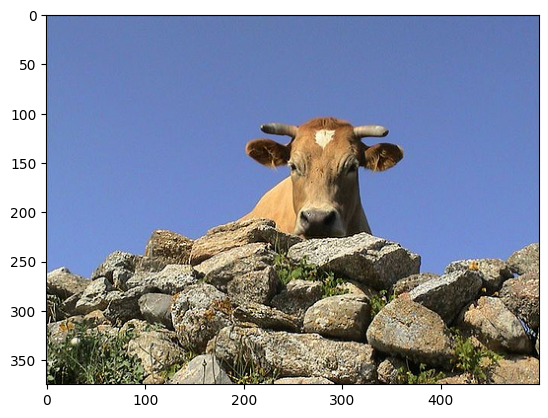

Image shape:  (375, 500, 3)
Image min-max value: 0 - 255 


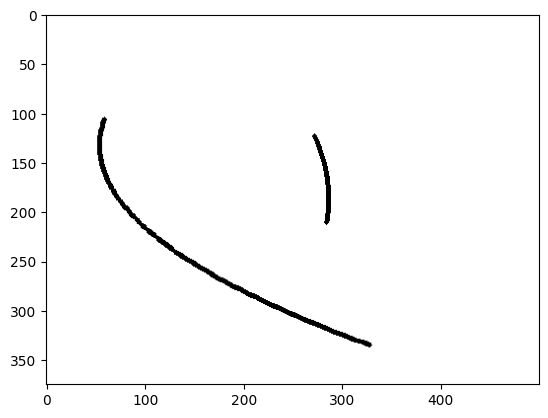

Scribble shape:  (375, 500, 3)
Unique value: [  0   1 255]


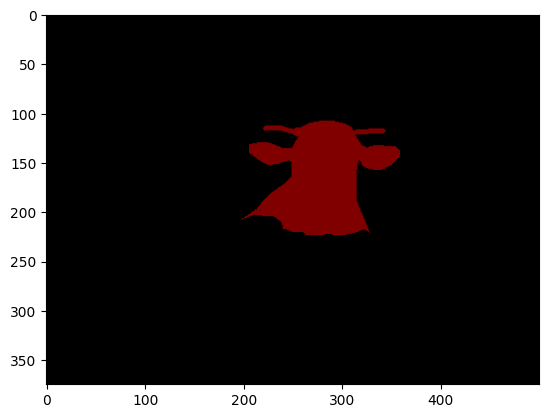

Ground Truth min-max value: 0 - 1 
Ground Truth shape:  (375, 500)
[0 1]
Number of colors:  (768,)


In [3]:
random_idx = random.randint(0, 227)
path = os.listdir(train_images_folder)[random_idx]
image_path = os.path.join(train_images_folder, path)
scribble_path = os.path.join(train_scribbles_folder, path)[:-3] + "png"
ground_truth_path = os.path.join(train_ground_truth_folder, path)[:-3] + "png"

image = Image.open(image_path)
scribble = Image.open(scribble_path)
ground_truth = Image.open(ground_truth_path)
pallete = Image.open(ground_truth_path).getpalette()

plt.imshow(image)
plt.show()
print("Image shape: ", np.array(image).shape)
print(f"Image min-max value: {np.min(image)} - {np.max(image)} ")

plt.imshow(scribble)
plt.show()
print("Scribble shape: ",np.array(scribble).shape)
print("Unique value:", np.unique(np.array(scribble)))

plt.imshow(ground_truth)
plt.show()
print(f"Ground Truth min-max value: {np.min(ground_truth)} - {np.max(ground_truth)} ")
print("Ground Truth shape: ", np.array(ground_truth).shape)
print(np.unique(np.array(ground_truth)))

print("Number of colors: ", np.array(pallete).shape)

## Load data

In [4]:
images_train, scrib_train, gt_train, fnames_train, palette = load_dataset(
       train_images_folder, train_scribbles_folder, train_ground_truth_folder
    )
print("Stack images:", images_train.shape)
print("Stack scribbles:", scrib_train.shape)
print(gt_train.shape)
print(len(fnames_train))

Stack images: (228, 375, 500, 3)
Stack scribbles: (228, 375, 500)
(228, 375, 500)
228


## Augmentation

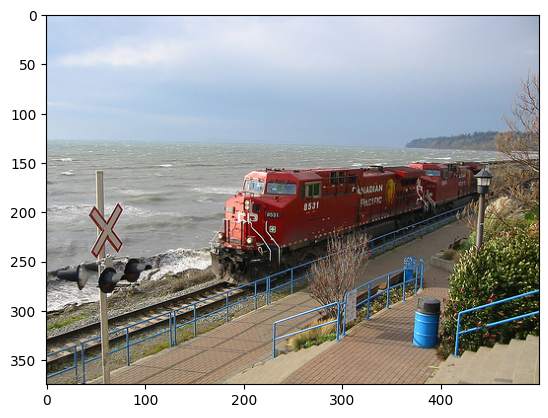

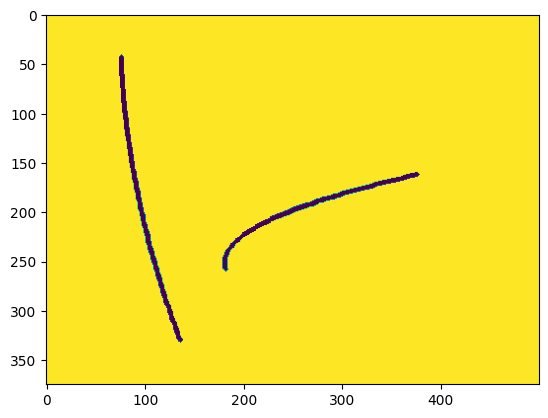

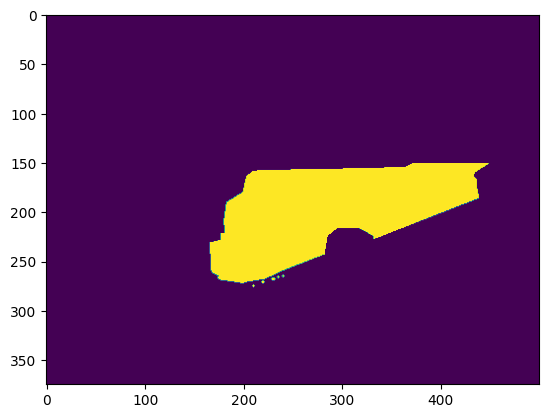

In [5]:
augmentation = CustomAugmentation(p=0.5)
sample_image = Image.fromarray(images_train[0])
sample_scrib = Image.fromarray(scrib_train[0])
sample_gt = Image.fromarray(gt_train[0])
plt.imshow(sample_image)
plt.show()
plt.imshow(sample_scrib)
plt.show()
plt.imshow(sample_gt)
plt.show()

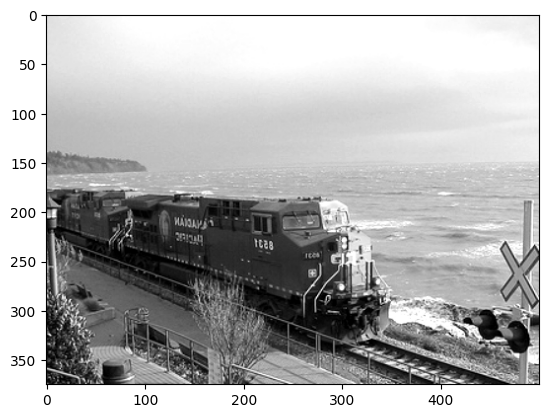

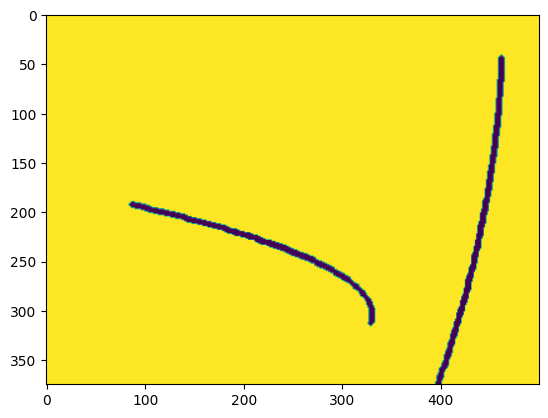

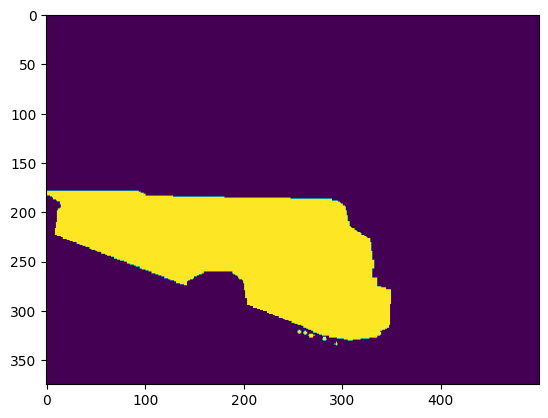

In [6]:
aug_image, aug_scrib, aug_gt = augmentation(sample_image, sample_scrib, sample_gt)
plt.imshow(aug_image)
plt.show()
plt.imshow(aug_scrib)
plt.show()
plt.imshow(aug_gt)
plt.show()

## Normalize image

Original image:


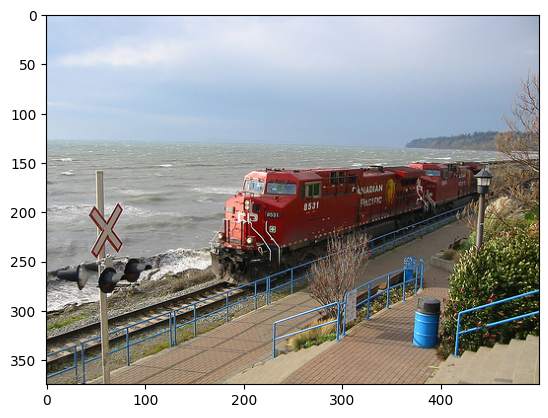

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Normalized image:
torch.Size([375, 500, 3])


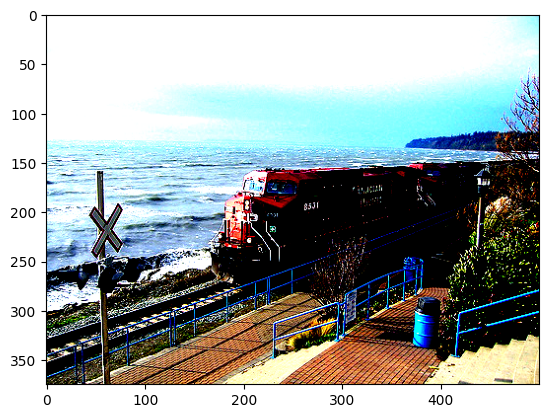

In [7]:
transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
image = images_train[0]
print("Original image:")
plt.imshow(image)
plt.show()

print("Normalized image:")
tf_image = transform(image).permute(1, 2, 0)
tf_image = torch.as_tensor(tf_image, dtype=torch.float64)
print(tf_image.shape)
plt.imshow(tf_image)
plt.show()

## Dataloader 

In [8]:
images_train, scrib_train, gt_train, fnames_train, palette = load_dataset(
       train_images_folder, train_scribbles_folder, train_ground_truth_folder
    )
train_dataset = ScribbleDataset(images_train, scrib_train, fnames_train, gt_train, augment_rate=0.5)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [9]:
images_test, scrib_test, gt_test, fnames_test, palette = load_dataset(
       test_images_folder, test_scribbles_folder, test_ground_truth_folder
    )
test_dataset = ScribbleDataset(images_test, scrib_test, fnames_test, gt_test, augment_rate=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [10]:
batch_images, batch_scribbles, batch_annos, batch_fnames = next(iter(train_loader))
print("Batch images:", batch_images.shape)
print("Batch scribbles:", batch_scribbles.shape)
print("Batch annotations:", batch_annos.shape)
print("File names:", batch_fnames)

Batch images: torch.Size([16, 3, 375, 500])
Batch scribbles: torch.Size([16, 1, 375, 500])
Batch annotations: torch.Size([16, 1, 375, 500])
File names: ('2009_001146.png', '2008_006784.png', '2008_004279.png', '2009_002591.png', '2008_004621.png', '2010_000160.png', '2008_008301.png', '2008_008545.png', '2009_004336.png', '2009_000532.png', '2008_006140.png', '2008_007143.png', '2009_001816.png', '2008_005713.png', '2008_005262.png', '2009_004732.png')


In [11]:
print(torch.max(batch_scribbles[0]))
print(torch.max(batch_annos[0]))


tensor(255.)
tensor(1.)


In [12]:
batch_images, batch_scribbles, batch_annos, batch_fnames = next(iter(test_loader))
print("Batch images:", batch_images.shape)
print("Batch scribbles:", batch_scribbles.shape)
print("Batch annotations:", batch_annos.shape)
print("File names:", batch_fnames)

Batch images: torch.Size([16, 3, 375, 500])
Batch scribbles: torch.Size([16, 1, 375, 500])
Batch annotations: torch.Size([16, 1, 375, 500])
File names: ('2010_001448.png', '2011_001534.png', '2011_002379.png', '2011_000895.png', '2011_001974.png', '2011_003003.png', '2010_002025.png', '2010_002348.png', '2010_005746.png', '2010_000788.png', '2010_001386.png', '2010_002097.png', '2011_003146.png', '2010_001011.png', '2011_000551.png', '2010_005922.png')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


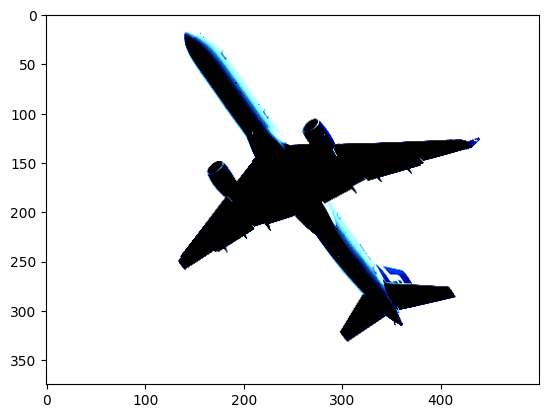

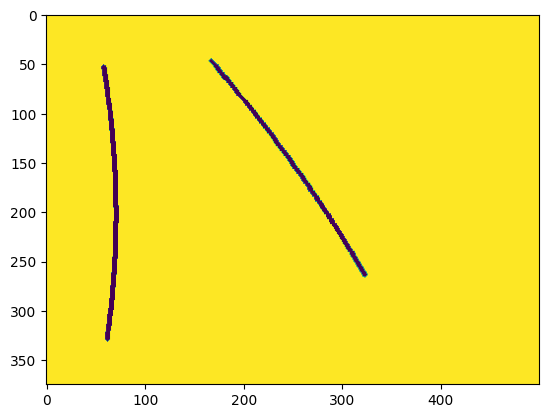

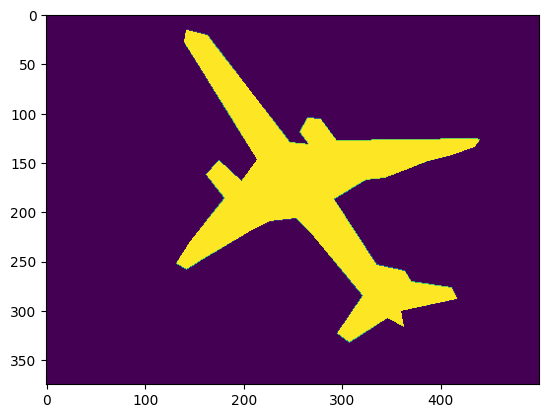

In [13]:
plt.imshow(batch_images[0].permute(1, 2, 0))
plt.show()
plt.imshow(batch_scribbles[0].permute(1, 2, 0))
plt.show()
plt.imshow(batch_annos[0].permute(1, 2, 0))
plt.show()

# 2. Model 

## Unet

In [15]:
sample_input = torch.randn((1, 4, 375, 500))
unet = UNet()
sample_output = unet(sample_input)
print("Output shape:", sample_output.shape)
summary(unet, (4, 375, 500))

Output shape: torch.Size([1, 1, 375, 500])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 375, 500]           2,368
       BatchNorm2d-2         [-1, 64, 375, 500]             128
              ReLU-3         [-1, 64, 375, 500]               0
            Conv2d-4         [-1, 64, 375, 500]          36,928
       BatchNorm2d-5         [-1, 64, 375, 500]             128
              ReLU-6         [-1, 64, 375, 500]               0
        DoubleConv-7         [-1, 64, 375, 500]               0
         MaxPool2d-8         [-1, 64, 187, 250]               0
            Conv2d-9        [-1, 128, 187, 250]          73,856
      BatchNorm2d-10        [-1, 128, 187, 250]             256
             ReLU-11        [-1, 128, 187, 250]               0
           Conv2d-12        [-1, 128, 187, 250]         147,584
      BatchNorm2d-13        [-1, 128, 187, 250]             

## Residual Unet

In [16]:
sample_input = torch.randn((4, 4, 375, 500))
res_unet = ResUNet()
sample_output = res_unet(sample_input)
print("Output shape:", sample_output.shape)
summary(res_unet, (4, 375, 500))

Output shape: torch.Size([4, 1, 375, 500])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 375, 500]           1,184
       BatchNorm2d-2         [-1, 32, 375, 500]              64
              ReLU-3         [-1, 32, 375, 500]               0
            Conv2d-4         [-1, 32, 375, 500]           9,248
       BatchNorm2d-5         [-1, 32, 375, 500]              64
              ReLU-6         [-1, 32, 375, 500]               0
         ConvBlock-7         [-1, 32, 375, 500]               0
         MaxPool2d-8         [-1, 32, 187, 250]               0
            Conv2d-9         [-1, 64, 187, 250]          18,496
      BatchNorm2d-10         [-1, 64, 187, 250]             128
             ReLU-11         [-1, 64, 187, 250]               0
           Conv2d-12         [-1, 64, 187, 250]          36,928
      BatchNorm2d-13         [-1, 64, 187, 250]             

## Residual Attention Unet

In [17]:
sample_input = torch.randn((16, 4, 375, 500))
res_attn_unet = ResAttentionUNet()
sample_output = res_attn_unet(sample_input)
print("Output shape:", sample_output.shape)
summary(res_attn_unet, (4, 375, 500))

Output shape: torch.Size([16, 1, 375, 500])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 375, 500]           1,184
       BatchNorm2d-2         [-1, 32, 375, 500]              64
              ReLU-3         [-1, 32, 375, 500]               0
            Conv2d-4         [-1, 32, 375, 500]           9,248
       BatchNorm2d-5         [-1, 32, 375, 500]              64
              ReLU-6         [-1, 32, 375, 500]               0
            Conv2d-7         [-1, 32, 375, 500]             160
 ResidualConvBlock-8         [-1, 32, 375, 500]               0
         MaxPool2d-9         [-1, 32, 187, 250]               0
           Conv2d-10         [-1, 64, 187, 250]          18,496
      BatchNorm2d-11         [-1, 64, 187, 250]             128
             ReLU-12         [-1, 64, 187, 250]               0
           Conv2d-13         [-1, 64, 187, 250]          36

# 3. Loss

In [18]:
criterion = DiceBCELoss()
criterion(sample_output, batch_annos)

BCE: 0.6515955328941345
DICE: 0.6577428579330444


tensor(1.3093, grad_fn=<AddBackward0>)

# 4. DINO

In [19]:
from src.models.dino import *

In [ ]:
device = "cpu"
dino = DINO(UNet, UNet, device)
optimizer = torch.optim.AdamW(dino.parameters(), lr=1e-4)
dino_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
train_dino(dino,
           dino_loader,
           optimizer,
           device=device,
           num_epochs=1,
           tps=0.9,
           tpt= 0.04,
           beta= 0.9,
           m= 0.9)

Epoch: 1/1


# 5. Evaluation 

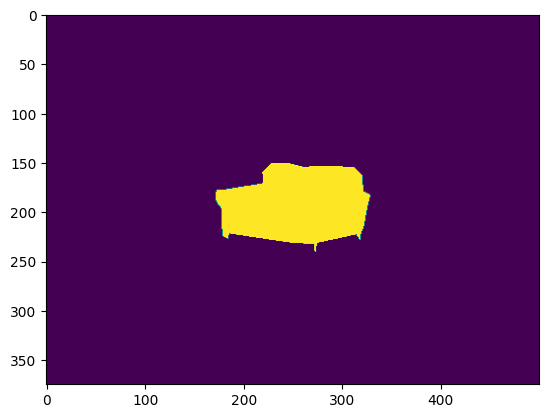

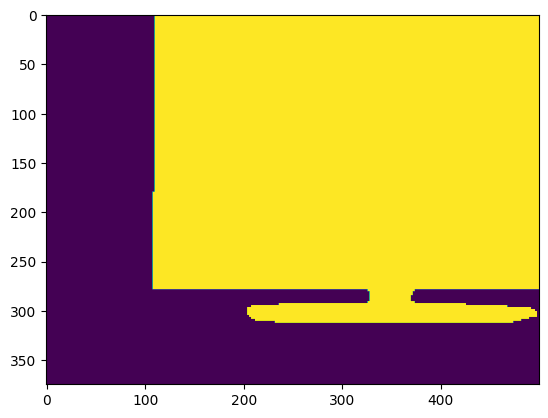

In [ ]:
sample_prediction = batch_annos[1]
sample_anno = batch_annos[2]
plt.imshow(sample_prediction.permute(1, 2, 0))
plt.show()
plt.imshow(sample_anno.permute(1, 2, 0))
plt.show()

In [ ]:
iou_criterion = IoULoss()
iou_loss = iou_criterion(sample_prediction, sample_anno) 
print(iou_loss)
print(np.array(sample_prediction).shape)
ious = evaluate_binary_miou(np.array(sample_prediction), np.array(sample_anno))
ious

tensor(0.6045)
(1, 375, 500)


{'iou_background': 0.40823408786181875,
 'iou_object': 0.08687715150039987,
 'miou': 0.2475556196811093}